# FIFA Statistical Tests

In this notebook, we will run statistical tests on the data using `numpy`, `scipy`, and `pandas`. 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv('fifa21_cleaned_data.csv')
df.head()

,photoUrl,LongName,playerUrl,Nationality,Positions,Name,Age,↓OVA,POT,Team & Contract,...,Hits,Height (ft),Height (in),BMI,Num_Positions,Team,Contract,Month,Day,Year
0,https://cdn.sofifa.com/players/158/023/21_60.png,Lionel Messi,http://sofifa.com/player/158023/lionel-messi/2...,Argentina,RW ST CF,L. Messi,33,93,93,FC Barcelona 2004 - 2021,...,372.0,5,7,24.900200,3,FC Barcelona,2004 - 2021,Jul,1,2004
1,https://cdn.sofifa.com/players/020/801/21_60.png,C. Ronaldo dos Santos Aveiro,http://sofifa.com/player/20801/c-ronaldo-dos-s...,Portugal,ST LW,Cristiano Ronaldo,35,92,92,Juventus 2018 - 2022,...,344.0,6,2,23.493243,2,Juventus,2018 - 2022,Jul,10,2018
2,https://cdn.sofifa.com/players/200/389/21_60.png,Jan Oblak,http://sofifa.com/player/200389/jan-oblak/210005/,Slovenia,GK,J. Oblak,27,91,93,Atlético Madrid 2014 - 2023,...,86.0,6,2,24.648649,1,Atlético Madrid,2014 - 2023,Jul,16,2014
3,https://cdn.sofifa.com/players/192/985/21_60.png,Kevin De Bruyne,http://sofifa.com/player/192985/kevin-de-bruyn...,Belgium,CAM CM,K. De Bruyne,29,91,91,Manchester City 2015 - 2023,...,163.0,5,11,21.476294,2,Manchester City,2015 - 2023,Aug,30,2015
4,https://cdn.sofifa.com/players/190/871/21_60.png,Neymar da Silva Santos Jr.,http://sofifa.com/player/190871/neymar-da-silv...,Brazil,LW CAM,Neymar Jr,28,91,91,Paris Saint-Germain 2017 - 2022,...,273.0,5,9,22.148708,2,Paris Saint-Germain,2017 - 2022,Aug,3,2017


### Statistical Test 1: Is there a significant difference in the overall rating of players from different nationalities?

**Test: One-Way ANOVA** 

We can assume that there is a normal distirbution within each group, and that there is a homogeneity of variances.

The results below are for $$ \alpha = 0.05 $$

In [36]:
from scipy.stats import f_oneway
nationalities = df['Nationality'].unique() # Get unique Countries
anova_results = {} # Save anova results into a dictionary

for nationality in nationalities:
    group = df[df['Nationality'] == nationality]['↓OVA']
    anova_results[nationality] = group
f_statistic, p_value = f_oneway(*anova_results.values())
print('F-statistic:{}'.format(f_statistic))
print('P-value: {}'.format(p_value))


F-statistic:24.251183860655658
P-value: 0.0


We can reject the null hypothesis. There is a signficiant difference in Overall Ratings between nationalities as the p-value is less than the alpha value. 

### Statistical Test 2: Is there a significant difference in the average age of players between FC Barcelona and Juventus? 

**Test: Independent two-sample t-test.**

We can assume that there is a normal distribution of age within each team and independence of samples.
The results below are for $$ \alpha = 0.05 $$

In [37]:
from scipy.stats import ttest_ind

barcelona_ages = df[df['Team'] == 'FC Barcelona ']['Age']
juventus_ages = df[df['Team'] == 'Juventus ']['Age']
t_stat, p_value = ttest_ind(barcelona_ages, juventus_ages, equal_var = False)
print('T-statistic:{}'.format(t_stat))
print('P-value: {}'.format(p_value))


T-statistic:-1.41349201401397
P-value: 0.16341762792730494


We cannot reject the null hypothesis. There is no significant difference in the average age of players between FC Barcelona and Juventus.

### Statistical Test 3: Is there a singificant relationship between a goalkeeper's height and their diving ability? 

**Test: Pearson correlation coefficient**

We can assume linearity, normality, and homoscedasticity. 

In [38]:
from scipy.stats import pearsonr
goalkeeper_height = df[df['Positions'].str.contains('GK', case=False)] ['Height (ft)'] * 12 
+df[df['Positions'].str.contains('GK', case=False)] ['Height (in)']
goalkeeper_diving = df[df['Positions'].str.contains('GK', case=False)] ['GK Diving']
correlation_coefficient, _ = pearsonr(goalkeeper_height, goalkeeper_diving)
print("Correlation Coefficient: {}".format(correlation_coefficient))



Correlation Coefficient: 0.12350369921438165


There is no strong linear relationship between a goalkeeper's height and their diving ability. 

### Statistical Test 4: Do players with high attacking skills tend to have lower defending skills? 
**Test: Spearman Rank Correlation**
We can assume that there is a monotonic relationship and that there is an independence of observations.
The results below are for $$ \alpha = 0.05 $$

In [39]:
from scipy.stats import spearmanr

player_skills_info = df[['Attacking', 'Defending']].dropna()
correlation_coefficient, p_value = spearmanr(player_skills_info['Attacking'], player_skills_info['Defending'])
print("Correlation Coefficient: {}".format(correlation_coefficient))
print("P-Value: {}".format(p_value))

Correlation Coefficient: 0.19587559237875235
P-Value: 1.792687946632558e-163


We can reject the null hypothesis. There is a significant correlaiton between attacking and defending skills.

### Statistical Test 5: Can we predict a player's overall rating based on their different attributes?

**Test: Linear Regression Model Using Sci-Kit Learn ML**

Mean Squared Error: 11.354564538176183
R-squared: 0.7666698109050804


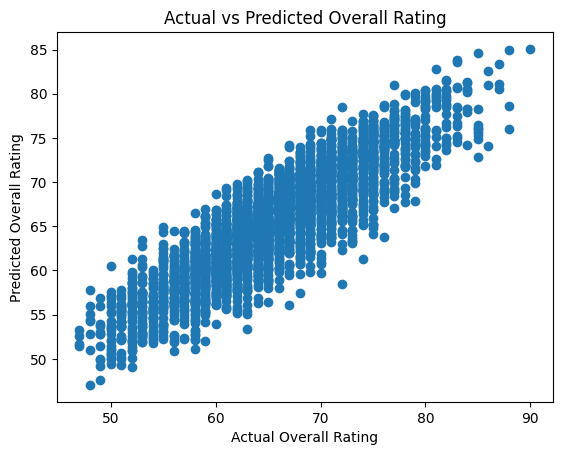

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

attributes = ['PAC','SHO','PAS','DRI','DEF','PHY']  # Chosen attributes
X = df[attributes]
y = df['↓OVA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.title('Actual vs Predicted Overall Rating')
plt.show()


Conclusion: We can predict a player's overall rating based on their different attributes. 